In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/MyDrive/Learn_NLP/2Cap_picture

/content/drive/MyDrive/Learn_NLP/2Cap_picture


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten,Reshape, GRU, LSTM, Embedding, AveragePooling2D, Concatenate, Add, Input, Dropout
from tensorflow.keras import Sequential, Model
from tensorflow.keras.applications import VGG16
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import os
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

In [ ]:
cnn_model = VGG16(input_shape=(224,224,3), include_top=True, weights='imagenet')
cnn_model = Model(inputs=cnn_model.input, outputs=cnn_model.layers[-3].output)
cnn_model.summary()

553476096/553467096 [==============================] - 3s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [ ]:
def img_to_feauture(path_img):
  img = image.load_img(path_img, target_size=(224,224))
  tensor = image.img_to_array(img)
  tensor = tensor/255.
  tensor = np.expand_dims(tensor, axis=0)
  feauture = cnn_model.predict(tensor)
  feauture = Flatten()(feauture)
  feauture = feauture[0]
  return feauture

In [ ]:
def process_sentence(sentence):
  new_sentence = 'startsent'
  desc = sentence.split()
  # convert to lower case
  desc = [word.lower() for word in desc]
  # remove hanging 's' and 'a'
  desc = [word for word in desc if len(word)>1]
  # remove punctuation from each token
  desc = [word[:-1] if word[-1] in ['.', ',', ';'] else word for word in desc]
  # remove tokens with numbers in them
  desc = [word for word in desc if word.isalpha()]
  # remove punctuation from each token
  for word in desc:
    new_sentence += ' ' + word
  new_sentence += ' ' + 'endsent'

  return new_sentence

In [ ]:
f = open('Flickr8k/text/Flickr8k.lemma.token.txt', 'r')

In [ ]:
data = f.readlines()

In [ ]:
print(len(data))

40460


In [ ]:
# Tách riêng ảnh, câu
imgs = []
sentences = []
for i in range(len(data)):
  spl = data[i].split("\t")
  img = spl[0]
  sentence = spl[1]
  imgs.append(img)
  sentences.append(process_sentence(sentence))

len(sentences)

40460

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)

In [ ]:
tokenizer.index_word

{1: 'startsent',
 2: 'endsent',
 3: 'in',
 4: 'be',
 5: 'on',
 6: 'the',
 7: 'dog',
 8: 'and',
 9: 'man',
 10: 'with',
 11: 'of',
 12: 'two',
 13: 'boy',
 14: 'girl',
 15: 'woman',
 16: 'person',
 17: 'white',
 18: 'black',
 19: 'run',
 20: 'play',
 21: 'wear',
 22: 'stand',
 23: 'to',
 24: 'at',
 25: 'jump',
 26: 'water',
 27: 'child',
 28: 'young',
 29: 'red',
 30: 'an',
 31: 'brown',
 32: 'his',
 33: 'sit',
 34: 'blue',
 35: 'through',
 36: 'walk',
 37: 'while',
 38: 'hold',
 39: 'shirt',
 40: 'ball',
 41: 'down',
 42: 'little',
 43: 'ride',
 44: 'grass',
 45: 'look',
 46: 'snow',
 47: 'over',
 48: 'front',
 49: 'three',
 50: 'small',
 51: 'field',
 52: 'large',
 53: 'up',
 54: 'by',
 55: 'green',
 56: 'group',
 57: 'one',
 58: 'yellow',
 59: 'her',
 60: 'into',
 61: 'air',
 62: 'beach',
 63: 'mouth',
 64: 'near',
 65: 'player',
 66: 'rock',
 67: 'dress',
 68: 'bike',
 69: 'street',
 70: 'another',
 71: 'for',
 72: 'its',
 73: 'from',
 74: 'as',
 75: 'climb',
 76: 'watch',
 77: 'out

In [ ]:
vocab_size = len(tokenizer.word_index)+1
vocab_size

6293

In [ ]:
sequences = tokenizer.texts_to_sequences(sentences)
lengths = [len(sequence) for sequence in sequences]
max_length = max(lengths) - 1
max_length

32

In [ ]:
len(sequences)

40460

In [ ]:
direc = {}
for i in range(len(imgs)):
  direc[imgs[i][:-2]] = []
for i in range(len(imgs)):
  direc[imgs[i][:-2]].append(sequences[i])

In [ ]:
print(len(direc))

8092


In [ ]:
# Chuẩn bị dữ liệu X_train, Y_train (giới hạn 6000/8092 ảnh)
X_imgs, X_seqs, Y = [], [], []
n = 0
for img in direc:
  n += 1
  try:
    path_img = "Flickr8k/Imgs/" + img
    try:
      feauture = img_to_feauture(path_img)
    except Exception as e:
      print(e)
      continue
    
    five_seqs = direc[img]
    for seq in five_seqs:
      in_seq = seq[:-1]
      out_seq = seq[1:]
      # out_seq = to_categorical(out_seq, num_classes=vocab_size)

      X_imgs.append(feauture)
      X_seqs.append(in_seq)
      Y.append(out_seq)

  except Exception as e:
    print(e)
  
  if n%50==0:
    print(n)
  # if n==3000:
  #   break
  
X_imgs = np.array(X_imgs)
print('ok')
Y = pad_sequences(Y, maxlen=max_length, padding='post')
print('ok')
X_seqs = pad_sequences(X_seqs, maxlen=max_length, padding='post')
print('ok')

In [ ]:
print(X_seqs.shape)
print(X_seqs.shape)
print(Y.shape)

(40455, 32)
(40455, 32)
(40455, 32)


In [ ]:
np.save('Flickr8k/npy/X_imgs.npy', X_imgs)
np.save('Flickr8k/npy/X_seqs.npy', X_seqs)
np.save('Flickr8k/npy/Y.npy', Y)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 4096)]       0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 32)]         0           []                               
                                                                                                  
 dropout (Dropout)              (None, 4096)         0           ['input_2[0][0]']                
                                                                                                  
 embedding (Embedding)          (None, 32, 64)       402752      ['input_3[0][0]']                
                                                                                            

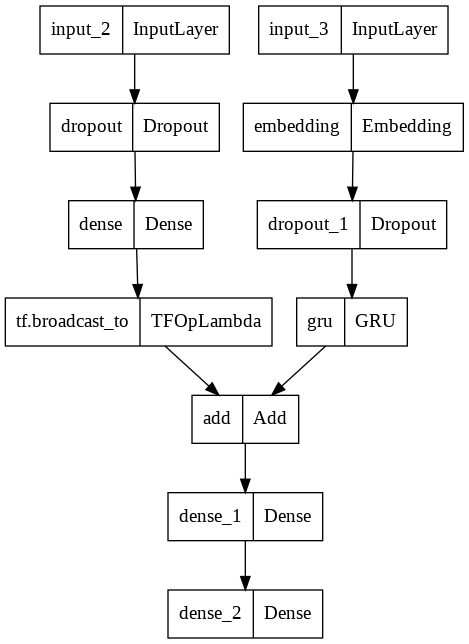

In [ ]:
# Build model
def build_model(embedding_dim=64):
  inputs1 = Input(shape=(4096,))
  fe1 = Dropout(0.5)(inputs1)
  fe2 = Dense(256, activation='relu')(fe1)
  fe3 = tf.broadcast_to(fe2, [max_length, 256])

  inputs2 = Input(shape=(max_length,))
  se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
  se2 = Dropout(0.5)(se1)
  se3 = GRU(256, return_sequences=True)(se2)

  # decoder1 = Add()([fe3, se3])
  decoder2 = Dense(256, activation='relu')(se3)
  outputs = Dense(vocab_size, activation='softmax')(decoder2)
  model = Model(inputs=[inputs1, inputs2], outputs=outputs)

  return model

model = build_model(64)
model.summary()
tf.keras.utils.plot_model(model, "/content/model.png")

In [ ]:
def build_loss_fcn():
  """......"""

In [ ]:
model.compile(loss=build_loss_fcn, optimizer='adam')

In [ ]:
# step = int(8091/1)
epochs = 10
for i in range(epochs):
  generator = data_generator(num_imgs_per_batch=1)
  model.fit_generator(generator, epochs=1, verbose=1, steps_per_epoch=1000)

   1/1000 [..............................] - ETA: 22s - loss: 4.9691

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


1000/1000 [==============================] - 57s 57ms/step - loss: 2.9389


In [ ]:
model.save_weights('Flickr8k/model_weights/my_model_1st.h5')

In [ ]:
model.load_weights('Flickr8k/model_weights/my_model_1st.h5')

In [ ]:
def predict_img_cap(path_img):
  feauture = img_to_feauture(path_img)
  feauture = np.expand_dims(feauture, axis=0)

  seq = tokenizer.texts_to_sequences(['startsent'])
  for i in range(max_length):
    in_seq = pad_sequences(seq, maxlen=max_length)
    # in_seq = np.expand_dims(in_seq, axis=0)
    out = model.predict([feauture, in_seq])[0]
    out_seq = np.argmax(out)
    seq[0].append(out_seq)
    if out_seq==tokenizer.word_index['endsent']:
      break

  sent = tokenizer.sequences_to_texts(seq)
  return sent

startsent baseball batter raise his arm endsent
startsent baseball player from new york wait to bat during game endsent
startsent baseball player in yankee uniform be hold bat in one hand endsent
startsent new york yankee hold up bat endsent
startsent new york yankee warm up endsent


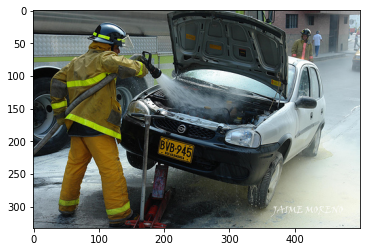

In [ ]:
path_img = 'Flickr8k/Imgs/'+ imgs[6][:-2]
img = plt.imread(path_img)
plt.imshow(img)
for i in range(25,30):
  print(sentences[i])

Flickr8k/Imgs/3563059800_c073081ce3.jpg
man in blue shirt be ride bull on track
haizz
Flickr8k/Imgs/3563673070_71fa0903ed.jpg
man in blue shirt be ride bull on track
haizz
Flickr8k/Imgs/3565598162_56044bc2f7.jpg
man in blue shirt be ride bull on track
haizz
Flickr8k/Imgs/3572346664_e1e6c77f11.jpg
man in blue shirt be ride bull on track
haizz
Flickr8k/Imgs/3574930742_9081bd2426.jpg
man in blue shirt be ride bull on track
haizz
Flickr8k/Imgs/3578372039_57473f473c.jpg
man in blue shirt be ride bull on track
haizz


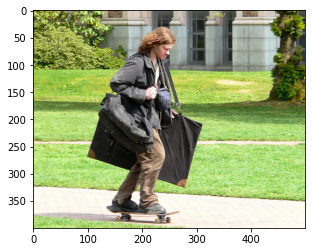

In [ ]:
for i in range(30000,30030,5):
  index = i
  path_img = 'Flickr8k/Imgs/'+ imgs[index][:-2]
  print(path_img)
  predict = predict_img_cap(path_img)
  print(predict[0][10:-8])
  print('haizz')
  img = plt.imread(path_img)
  plt.imshow(img)

In [ ]:
# uploaded = files.upload()

# for file_name in uploaded.keys():
#   path = file_name
#   img = cv2.imread(path)
#   anh = image.load_img(path)
#   print(img.shape)
#   face_cascade = cv2.CascadeClassifier('/content/drive/MyDrive/Predict_Age/haarcascade_frontalface_default.xml')
#   gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#   faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)
#   for (X_start, Y_start, X_range, Y_range) in faces:
#       cut_img = img[Y_start:Y_start+Y_range, X_start:X_start+X_range]
#       cv2.imwrite("/content/drive/MyDrive/Predict_Age/crop.jpg", cut_img)

#   img2 = image.load_img("/content/drive/MyDrive/Predict_Age/crop.jpg", target_size=(224, 224))
#   img3 = image.img_to_array(img2)
#   img3 = np.expand_dims(img3, axis=0)
#   img3 /= 255.
#   t = model2.predict(img3)

#   anhcrop = cv2.imread('/content/drive/MyDrive/Predict_Age/crop.jpg')
#   resized = cv2.resize(anhcrop, (150, 150))
#   cv2_imshow(resized)
#   print("Real Age  : {}".format(int(path[1:3])))
#   print("Prediction: {:.2f}".format(t[0][0]))